## Building Faces out of Parts

In this script we will extract facial parts from face images (using labeled landmark points available in the dataset) and create new seperate datasets of eyes, noses and mouths.

We then continue to analyze these face parts using kmeans and present the typical eyes, typical noses and typical mouths.

Finally, we take these parts and compose (generate) new funny looking faces out of them.

***Note:*** I've hidden most of the code, but remeber that the code here is extreemly simple and short. You are welcome to both unhide and read it, or better yet fork the script and play around with it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform as tf
from sklearn import cluster

## Load the Data


In [2]:
#% load the dataset
face_images_db = np.load('../input/face_images.npz')['face_images']
facial_keypoints_df = pd.read_csv('../input/facial_keypoints.csv')

## Keep only the images with all 15 keypoints Fully Marked

In [3]:
numMissingKeypoints = facial_keypoints_df.isnull().sum(axis=1)
allKeypointsPresentInds = np.nonzero(numMissingKeypoints == 0)[0]

faceImagesDB = face_images_db[:,:,allKeypointsPresentInds]
facialKeypointsDF = facial_keypoints_df.iloc[allKeypointsPresentInds,:].reset_index(drop=True)

(imHeight, imWidth, numImages) = faceImagesDB.shape
numKeypoints = facialKeypointsDF.shape[1] / 2

print('number of remaining images = %d' %(numImages))
print('image dimentions = (%d,%d)' %(imHeight,imWidth))
print('number of facial keypoints = %d' %(numKeypoints))

number of remaining images = 2140
image dimentions = (96,96)
number of facial keypoints = 15


## Show Random subset of images with all 15 keypoints overlaid 

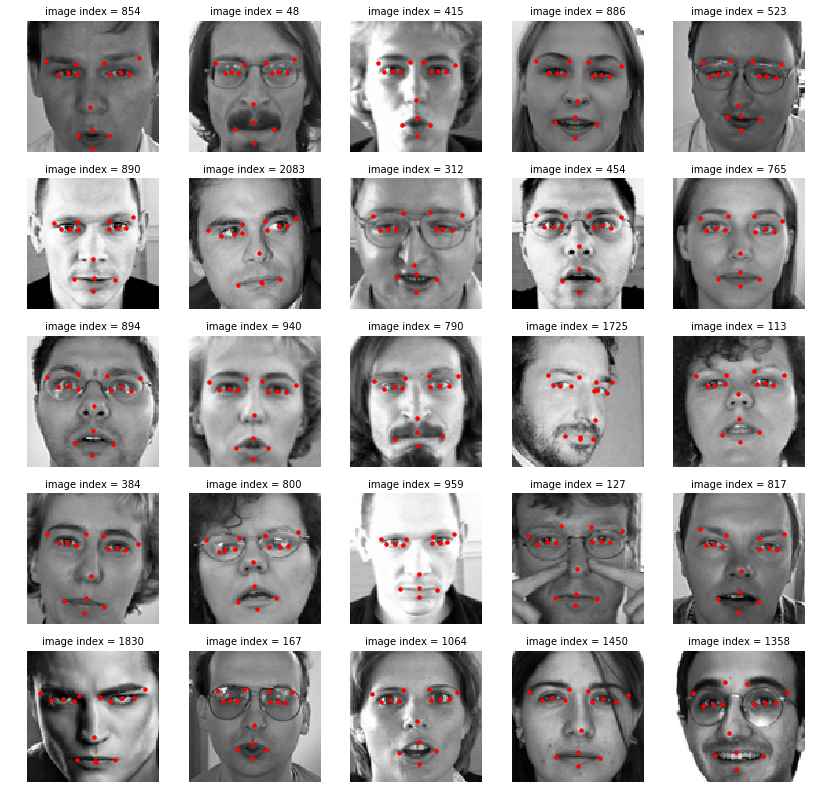

In [4]:
# show a random subset of images from the dataset
num_fig_rows = 5
num_fig_cols = 5

num_plots = num_fig_rows * num_fig_cols

rand_inds_vec = np.random.choice(faceImagesDB.shape[2],num_plots,replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

plt.close('all')
fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(14,14))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = faceImagesDB[:,:,curr_ind]
    
        x_feature_coords = np.array(facialKeypointsDF.iloc[curr_ind,0:30:2].tolist())
        y_feature_coords = np.array(facialKeypointsDF.iloc[curr_ind,1:30:2].tolist())
    
        ax[i][j].imshow(curr_image, cmap='gray');
        ax[i][j].scatter(x_feature_coords,y_feature_coords,c='r',s=12)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)

## Define Crop Boundaries for the Eyes, Nose and Mouth
(I've hidden this code since it's just boring crop boundry calculations from the keypoints, but you are welcome to unhide and look around)


In [5]:
# crop boundery for the left eye
listOfKeypointsToAvg = ['left_eye_center_x','left_eye_inner_corner_x','left_eye_outer_corner_x']
facialKeypointsDF['left_eye_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['left_eye_center_y','left_eye_inner_corner_y','left_eye_outer_corner_y']
facialKeypointsDF['left_eye_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

dy1 =   facialKeypointsDF['left_eye_BB_y'] - facialKeypointsDF['left_eyebrow_inner_end_y']
dy2 =   facialKeypointsDF['left_eye_BB_y'] - facialKeypointsDF['left_eyebrow_outer_end_y']
dx1 =   facialKeypointsDF['left_eye_BB_x'] - facialKeypointsDF['left_eyebrow_inner_end_x']
dx2 = -(facialKeypointsDF['left_eye_BB_x'] - facialKeypointsDF['left_eyebrow_outer_end_x'])
facialKeypointsDF['left_eye_halfHeight'] = 1.1*0.5*(dy1 + dy2)
facialKeypointsDF['left_eye_halfWidth']  = 1.1*0.5*(dx1 + dx2)


# crop boundry for the right eye
listOfKeypointsToAvg = ['right_eye_center_x','right_eye_inner_corner_x','right_eye_outer_corner_x']
facialKeypointsDF['right_eye_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['right_eye_center_y','right_eye_inner_corner_y','right_eye_outer_corner_y']
facialKeypointsDF['right_eye_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

dy1 =   facialKeypointsDF['right_eye_BB_y'] - facialKeypointsDF['right_eyebrow_inner_end_y']
dy2 =   facialKeypointsDF['right_eye_BB_y'] - facialKeypointsDF['right_eyebrow_outer_end_y']
dx1 =   facialKeypointsDF['right_eye_BB_x'] - facialKeypointsDF['right_eyebrow_inner_end_x']
dx2 = -(facialKeypointsDF['right_eye_BB_x'] - facialKeypointsDF['right_eyebrow_outer_end_x'])
facialKeypointsDF['right_eye_halfHeight'] = 1.1*0.5*(dy1 + dy2)
facialKeypointsDF['right_eye_halfWidth']  = -1.1*0.5*(dx1 + dx2)


# crop boundry for the nose
listOfKeypointsToAvg = ['left_eye_inner_corner_x','right_eye_inner_corner_x','mouth_right_corner_x','mouth_left_corner_x','nose_tip_x']
facialKeypointsDF['nose_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['left_eye_inner_corner_y','right_eye_inner_corner_y','mouth_center_top_lip_y','nose_tip_y']
facialKeypointsDF['nose_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

dy1 = abs(facialKeypointsDF['left_eye_inner_corner_y']  - 0.5*(facialKeypointsDF['nose_tip_y']+facialKeypointsDF['mouth_center_top_lip_y']))
dy2 = abs(facialKeypointsDF['right_eye_inner_corner_y'] - 0.5*(facialKeypointsDF['nose_tip_y']+facialKeypointsDF['mouth_center_top_lip_y']))
dx1 = abs(facialKeypointsDF['left_eye_inner_corner_x']  - facialKeypointsDF['right_eye_inner_corner_x'])
dx2 = abs(facialKeypointsDF['mouth_left_corner_x']      - facialKeypointsDF['mouth_right_corner_x'])
facialKeypointsDF['nose_halfWidth']  = 0.25*(dx1 + dx2)
facialKeypointsDF['nose_halfHeight'] = 0.25*(dy1 + dy2)


# crop boundry for the mouth
listOfKeypointsToAvg = ['mouth_center_top_lip_x','mouth_center_bottom_lip_x','mouth_right_corner_x','mouth_left_corner_x']
facialKeypointsDF['mouth_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['mouth_center_top_lip_y','mouth_center_bottom_lip_y','mouth_right_corner_y','mouth_left_corner_y']
facialKeypointsDF['mouth_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

facialKeypointsDF['mouth_halfWidth']  = 1.3*0.5*abs(facialKeypointsDF['mouth_left_corner_x']    - facialKeypointsDF['mouth_right_corner_x'])
facialKeypointsDF['mouth_halfHeight'] = 7.0 + 0.95*0.5*abs(facialKeypointsDF['mouth_center_top_lip_y'] - facialKeypointsDF['mouth_center_bottom_lip_y'])


In [6]:
# show the newly formed columns
facialKeypointsDF.iloc[:5,30:]

,left_eye_BB_x,left_eye_BB_y,left_eye_halfHeight,left_eye_halfWidth,right_eye_BB_x,right_eye_BB_y,right_eye_halfHeight,right_eye_halfWidth,nose_BB_x,nose_BB_y,nose_halfWidth,nose_halfHeight,mouth_BB_x,mouth_BB_y,mouth_halfWidth,mouth_halfHeight
0,66.248662,39.539898,9.799905,12.800626,30.012150,37.066827,8.516124,13.129177,46.033805,51.759771,13.951579,13.241359,44.063278,78.695098,21.177528,12.486400
1,64.637277,35.477197,6.749887,13.555745,30.152170,33.651563,7.754023,14.224919,46.928204,48.890843,11.030128,14.072902,45.924085,77.036596,13.844391,14.226468
2,65.151158,35.850526,6.313166,12.729663,31.186105,35.944611,6.416659,13.971505,47.839326,49.093168,12.207632,12.772200,47.274789,73.649368,17.612811,11.022100
3,65.847930,38.256640,7.654730,11.812049,31.649670,38.007930,8.281091,11.667423,50.470289,50.534880,12.684522,11.594233,51.177183,73.814817,18.429704,10.883930
4,65.935706,39.708996,9.354713,11.282356,30.577767,38.480707,8.444620,12.160261,46.142194,54.328255,12.765791,14.970199,45.263264,78.774773,19.161777,13.252795


## Plot the Resulting Bounding Boxes of the Eyes, Nose and Mouth 

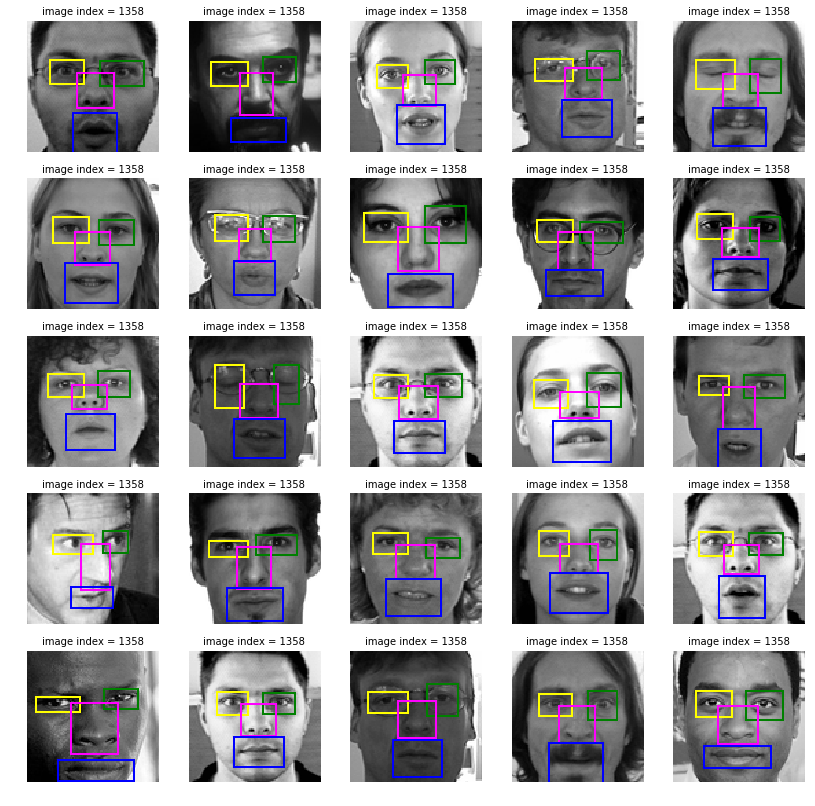

In [7]:
# helper function to convert dataframe fields to rectangle fields
def ExtractBoundingBoxParams(df, fieldNamePremble):
    bottomLeft_x = df.loc[k, fieldNamePremble + '_BB_x'] - df.loc[k, fieldNamePremble + '_halfWidth']
    bottomLeft_y = df.loc[k, fieldNamePremble + '_BB_y'] - df.loc[k, fieldNamePremble + '_halfHeight']
    boxWidth     = 2*df.loc[k, fieldNamePremble + '_halfWidth']
    boxHeight    = 2*df.loc[k, fieldNamePremble + '_halfHeight']
    return bottomLeft_x, bottomLeft_y, boxWidth, boxHeight


num_fig_rows = 5
num_fig_cols = 5
num_plots = num_fig_rows * num_fig_cols
rand_inds_vec = np.random.choice(faceImagesDB.shape[2],num_plots,replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(14,14))
for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        k = rand_inds_mat[i][j]
        curr_image = faceImagesDB[:,:,k]
    
        x_feature_coords = np.array(facialKeypointsDF.iloc[k,0:30:2].tolist())
        y_feature_coords = np.array(facialKeypointsDF.iloc[k,1:30:2].tolist())
    
        ax[i][j].imshow(curr_image, cmap='gray');
        #ax[i][j].scatter(x_feature_coords,y_feature_coords,c='r',s=12)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)

        # plot bounding box of all parts with corresponding colors
        listOfPartNames  = [ 'left_eye', 'right_eye',    'nose', 'mouth']
        listOfPartColors = [    'green',    'yellow', 'magenta',  'blue']
        
        for partName, partColor in zip(listOfPartNames, listOfPartColors):
            bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, partName)
            ax[i][j].add_patch(patches.Rectangle( (bottomLeft_x, bottomLeft_y), boxWidth, boxHeight,
                                                   edgecolor=partColor, linewidth=2, fill=False) )

## Define target size of the facial parts
(this is just calculating the mean face part bounding box size for each face part)

In [8]:
#%% determine part target sizes
targetEyeSize = (np.ceil(2*facialKeypointsDF['left_eye_halfHeight'].mean()),np.ceil(2*facialKeypointsDF['left_eye_halfWidth'].mean()))
targetEyeSize = [int(x) for x in targetEyeSize]

targetNoseSize = (np.ceil(2*facialKeypointsDF['nose_halfHeight'].mean()),np.ceil(2*facialKeypointsDF['nose_halfWidth'].mean()))
targetNoseSize = [int(x) for x in targetNoseSize]

targetMouthSize = (np.ceil(2*facialKeypointsDF['mouth_halfHeight'].mean()),np.ceil(2*facialKeypointsDF['mouth_halfWidth'].mean()))
targetMouthSize = [int(x) for x in targetMouthSize]

## Create "Eyes", "Noses" and "Mouths" datasets from the bounding boxes
(crop and resize each to a standard size)

In [9]:
#%% go over all images, crop out parts and resize to fit the target size
allLeftEyes  = np.zeros((targetEyeSize[0]  , targetEyeSize[1]  , numImages))
allRightEyes = np.zeros((targetEyeSize[0]  , targetEyeSize[1]  , numImages))
allNoses     = np.zeros((targetNoseSize[0] , targetNoseSize[1] , numImages))
allMouths    = np.zeros((targetMouthSize[0], targetMouthSize[1], numImages))

for k in range(numImages):
    currImage = faceImagesDB[:,:,k]
    
    # crop out left eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'left_eye')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedLeftEye = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]
    
    # crop out right eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'right_eye')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedRightEye = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]

    # crop out right eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'nose')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedNose = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]

    # crop out right eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'mouth')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedMouth = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]
    
    allLeftEyes[:,:,k]  = tf.resize(croppedLeftEye,targetEyeSize)
    allRightEyes[:,:,k] = tf.resize(croppedRightEye,targetEyeSize)
    allNoses[:,:,k]     = tf.resize(croppedNose,targetNoseSize)
    allMouths[:,:,k]    = tf.resize(croppedMouth,targetMouthSize)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Look at some cropped "Eyes"

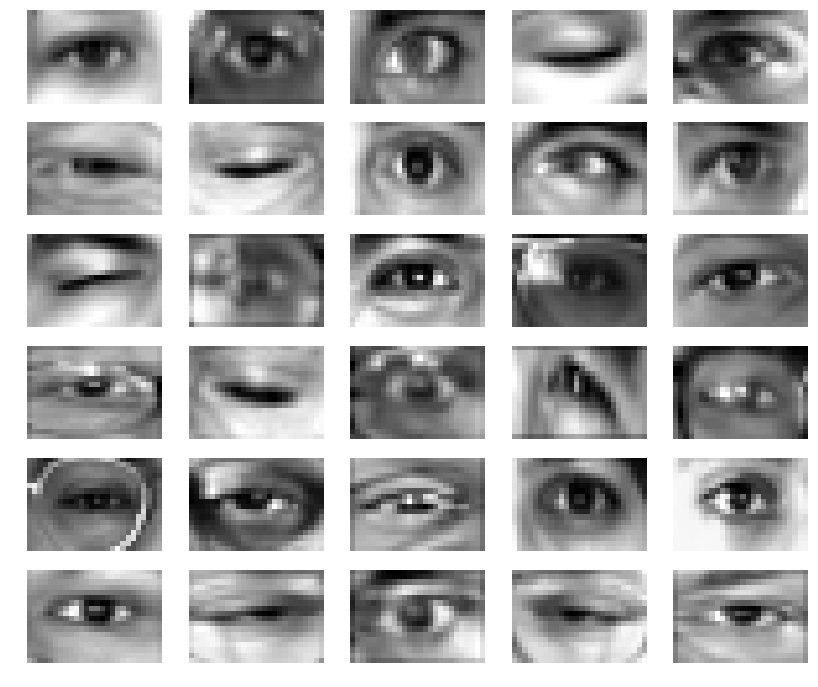

In [10]:
# plot eyes
numFigRows = 6
numFigCols = 5
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,12))
for i in range(numFigRows):
    for j in range(numFigCols):
        if np.random.rand(1) < 0.5:
            ax[i][j].imshow(allLeftEyes[:,:,randIndsMat[i][j]], cmap='gray');
        else:
            ax[i][j].imshow(np.fliplr(allLeftEyes[:,:,randIndsMat[i][j]]), cmap='gray');
        ax[i][j].set_axis_off()

## Look at some "Noses"

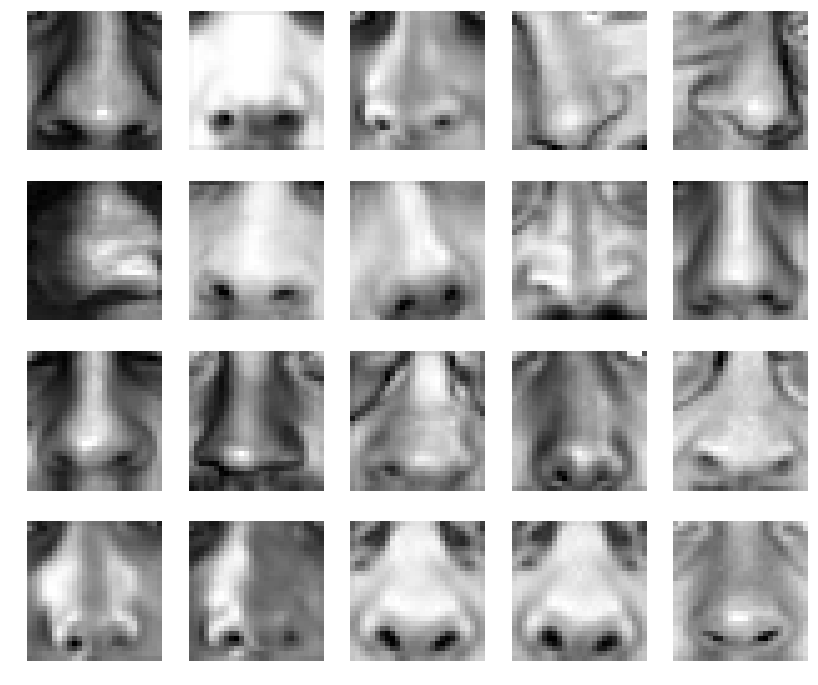

In [11]:
# plot noses
numFigRows = 4
numFigCols = 5
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,12))
for i in range(numFigRows):
    for j in range(numFigCols):
        ax[i][j].imshow(allNoses[:,:,randIndsMat[i][j]], cmap='gray');
        ax[i][j].set_axis_off()

## Look at some "Mouths"

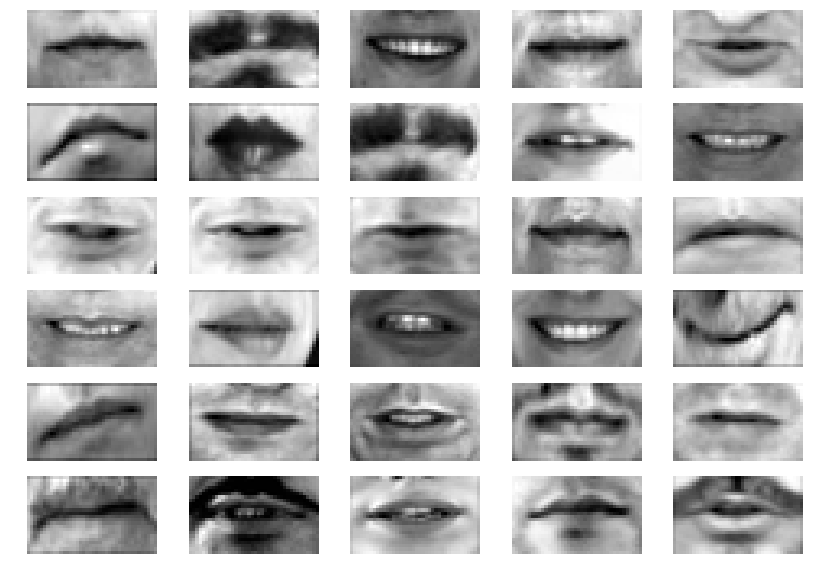

In [12]:
# plot mouths
numFigRows = 6
numFigCols = 5
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,10))
for i in range(numFigRows):
    for j in range(numFigCols):
        ax[i][j].imshow(allMouths[:,:,randIndsMat[i][j]], cmap='gray');
        ax[i][j].set_axis_off()

## Flatten the part images and create 'numSamples' by 'numFeatures' datasets
convert each image into a single vector. from shape (imHeight, imWidth) to shape (1,imHeight * imWidth)

In [13]:
#%% flatten the 3D datasets (imHeight,imWidth,numSamples) to 2D datasets (numSamples,numDimentions)
def FlattenImageDataset(imageDB):
    # assume imageDB.shape = (imHeight, imWidth, numSamples)
    numSamples = imageDB.shape[2]
    numFeatures = imageDB.shape[0] * imageDB.shape[1]
    imageDB_flattened = np.reshape(np.transpose(imageDB,axes=(2,0,1)),(numSamples,numFeatures))
    return imageDB_flattened

allLeftEyes_flat  = FlattenImageDataset(allLeftEyes)
allRightEyes_flat = FlattenImageDataset(np.fliplr(allRightEyes))
allNoses_flat     = FlattenImageDataset(allNoses)
allMouths_flat    = FlattenImageDataset(allMouths)

print('previous eye dataset shape was ' + str(allLeftEyes.shape))
print('current eye dataset shape is ' + str(allLeftEyes_flat.shape))

previous eye dataset shape was (18, 26, 2140)
current eye dataset shape is (2140, 468)


## Determine the number of clusters for each face part
We will do this by sequentially increasing the number of kmeans clusters and checking to see when we reach a sufficient amount of variance explained.   

**Note:** the percents explained by optimal clusters that try to explain the variance in a dataset (i.e. kmeans) are usually growing much slower than percents explained by optimal basis functions that try to explain the variance in a dataset (i.e. principlal components) so our target percent explained will be much more humble here.  
It might actually be fun to think about why that is, "if the reader is so inclined"?

## Determine the number of clusters for the Eyes


In [14]:
#%% determine the number of clusters for the eyes, nose and mouth
def DetermineNumClusters(imageDB_flattened, percentExplainedTarget=70, plotFigure=True):
    # run a loop in which you apply kmeans in increasing number of n_clusters and collect the inertia_ field from the result
    listOfNumClusters = [1,2,4,9,16,25,36,49,64,128,256]
    listOfInertia = []
    for numClusters in listOfNumClusters:
        KmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=750, n_init=1, random_state=1)
        KmeansModel.fit(imageDB_flattened)
        listOfInertia.append(KmeansModel.inertia_)
    explainedPercent = 100*(1-(np.array(listOfInertia)/listOfInertia[0]))

    # calculate the desired number of clusters
    try:
        numDesiredClusterInd = np.nonzero(explainedPercent > percentExplainedTarget)[0][0]
        numDesiredClusters = listOfNumClusters[numDesiredClusterInd]
    except:
        print("desired target exceeds %d" %(listOfNumClusters[-1]))
        numDesiredClusterInd = len(listOfNumClusters)
        numDesiredClusters = listOfNumClusters[numDesiredClusterInd]
            
    if plotFigure:
        # plot the explained percent as a function of number of clusters 
        explainedPercentReached = explainedPercent[numDesiredClusterInd]
        plt.figure(figsize=(14,6)); plt.plot(listOfNumClusters,explainedPercent,c='b')
        plt.scatter(numDesiredClusters,explainedPercentReached,s=150,c='r')
        plt.xlabel('Number of Clusters', fontsize=20); plt.ylabel('Explained Percent', fontsize=20)
        plt.title('Desired Number of Clusters = %d, Explained Percent = %.2f%s' %(numDesiredClusters,explainedPercentReached,'%'),fontsize=25)
        plt.xlim(-1,listOfNumClusters[-1]+1); plt.ylim(0,100)
    return numDesiredClusters

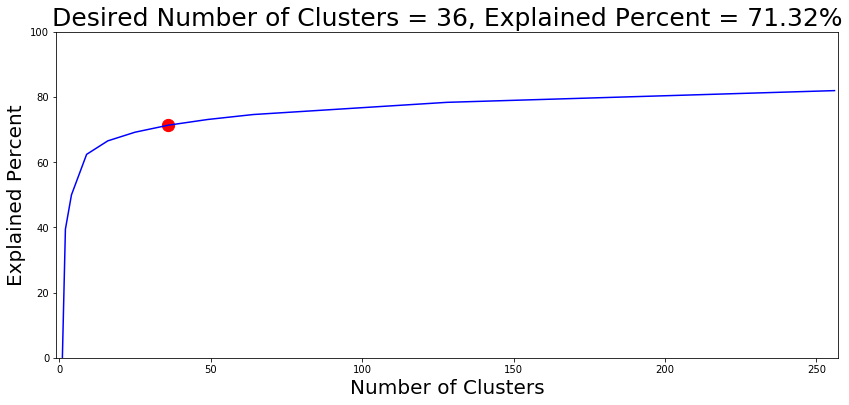

In [15]:
numClusters_eyes  = DetermineNumClusters(np.concatenate((allLeftEyes_flat, allRightEyes_flat)), plotFigure=True)

## Determine the number of clusters for the Noses
(I've hidden the output plot since it's similar to the previous plot) 

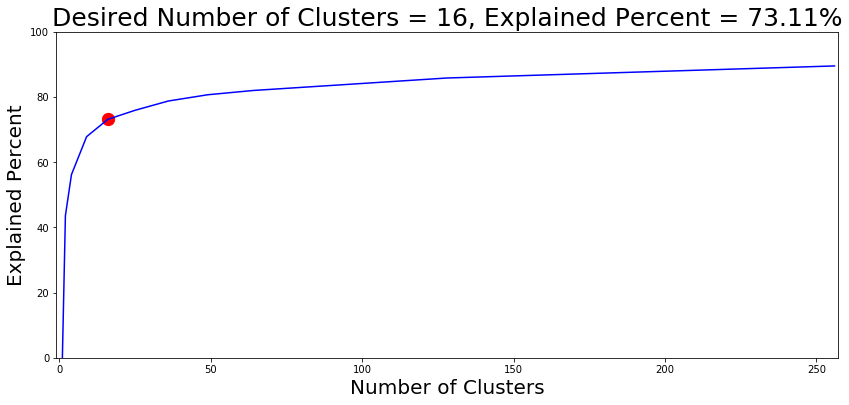

In [16]:
numClusters_nose  = DetermineNumClusters(allNoses_flat , plotFigure=True)

## Determine the number of clusters for the Mouths
(I've hidden the output plot since it's similar to the previous plot)

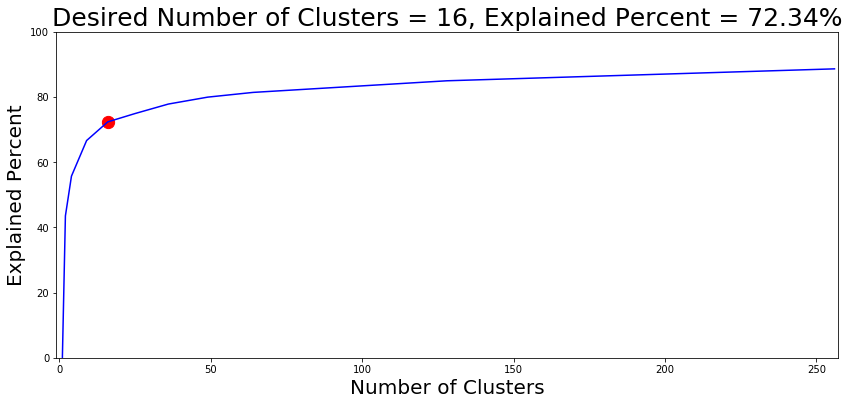

In [17]:
numClusters_mouth = DetermineNumClusters(allMouths_flat, plotFigure=True)

## Fit Kmeans Models with Desired Number of Clusters

In [18]:
#%% fit models with desired number of clusters
KmeansModel_nose  = cluster.KMeans(n_clusters=numClusters_nose , n_init=10, random_state=1)
KmeansModel_nose.fit(allNoses_flat)

KmeansModel_mouth = cluster.KMeans(n_clusters=numClusters_mouth, n_init=10, random_state=1)
KmeansModel_mouth.fit(allMouths_flat)

KmeansModel_eyes  = cluster.KMeans(n_clusters=numClusters_eyes , n_init=10, random_state=1)
KmeansModel_eyes.fit(np.concatenate((allLeftEyes_flat, allRightEyes_flat)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=36, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

## Show the Eye Clusters

In [19]:
#%% Show the resulting eye, nose and mouth clusters
def ShowKmeansClustersAsImages(KmeansModel, origImDims, title):
    clusterAssignments = KmeansModel.labels_
    subPlotRowsAndCols = np.ceil(np.sqrt(KmeansModel.n_clusters)).astype(int)
    
    plt.figure(figsize=(14,11));
    plt.suptitle(title, fontsize=30)
    for k in range(subPlotRowsAndCols**2):
        percentAssigned = 100.0 * (clusterAssignments == k).sum() / len(clusterAssignments)
        currCenterImage = np.reshape(KmeansModel.cluster_centers_[k,:],(origImDims[0],origImDims[1]))
    
        plt.subplot(subPlotRowsAndCols,subPlotRowsAndCols,k+1); plt.axis('off');
        plt.imshow(currCenterImage,cmap='gray');
        plt.title('%.2f%s assignment' %(percentAssigned,'%'), fontsize=11);

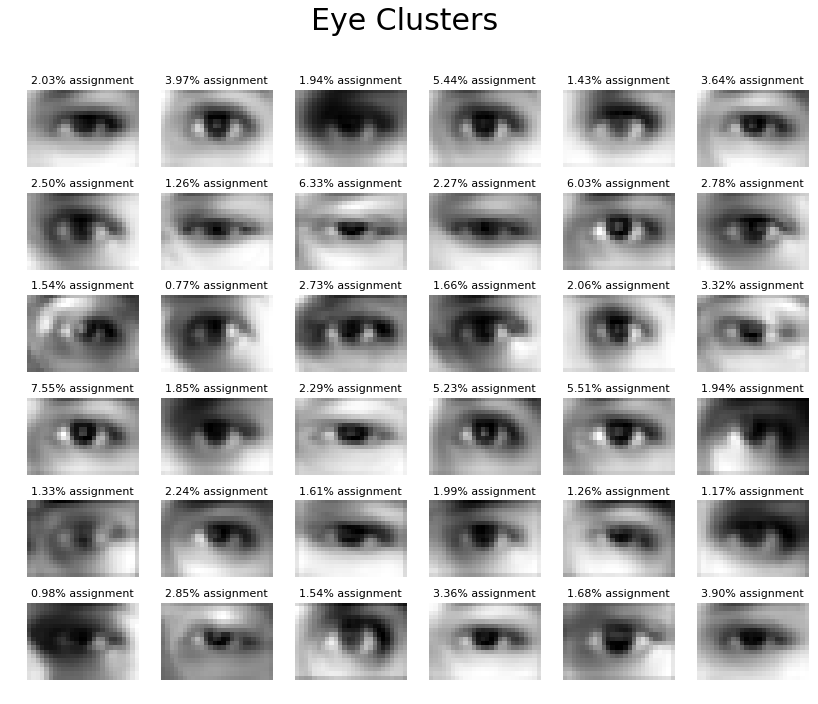

In [20]:
ShowKmeansClustersAsImages(KmeansModel_eyes , allLeftEyes.shape[0:2], 'Eye Clusters')

We can see quite interesting eyes here. open eyes, almost closed eyes, female eyes, male eyes, eyes with glasses. Intersting to look at.

## Show the Nose Clusters

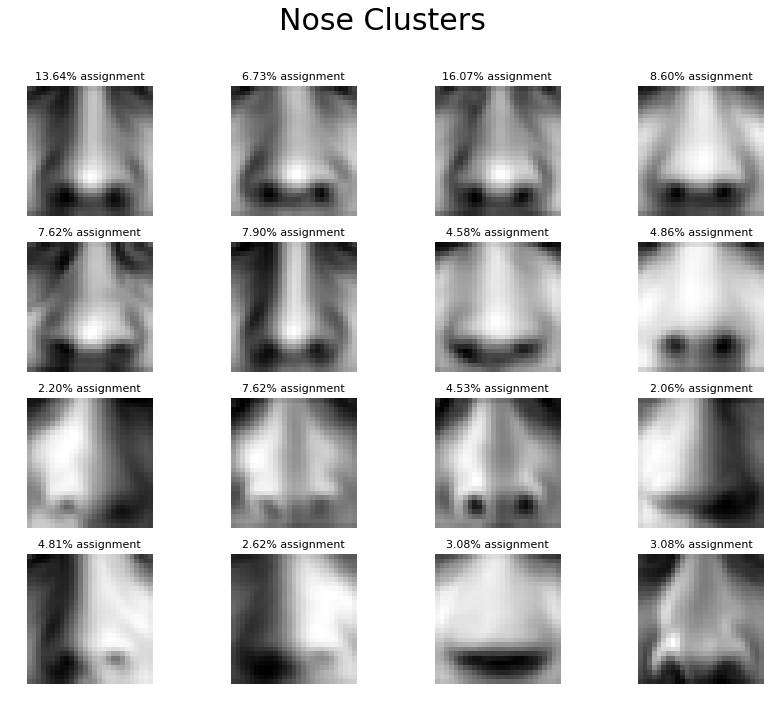

In [21]:
ShowKmeansClustersAsImages(KmeansModel_nose , allNoses.shape[0:2]   , 'Nose Clusters')

We can see noses that are lit from different angles, and noses that were taken from different angles, and we also see one nose that doesn't appear to have any nostrils...

## Show the Mouth Clusters

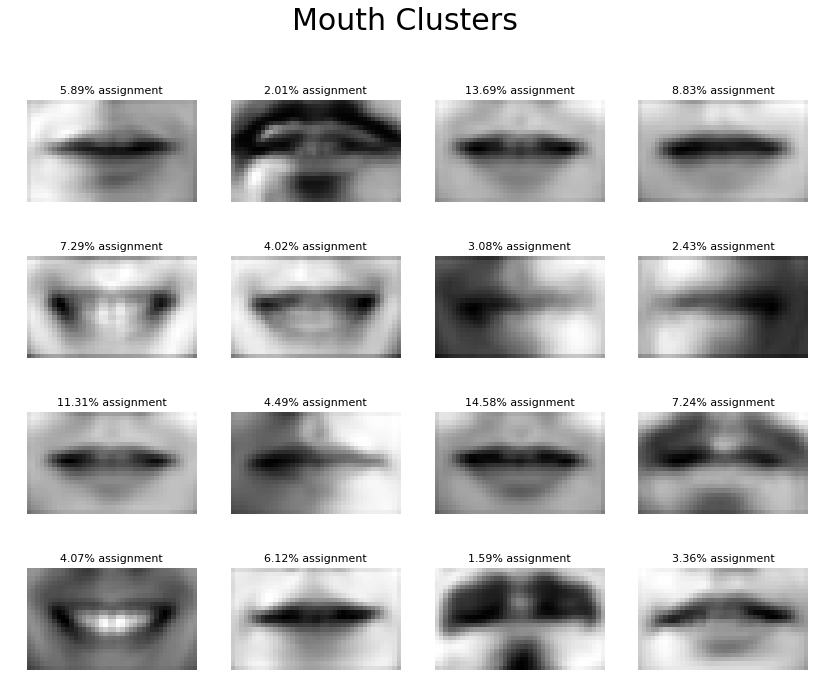

In [22]:
ShowKmeansClustersAsImages(KmeansModel_mouth, allMouths.shape[0:2]  , 'Mouth Clusters')

We can see here smiling mouths, male mouths, female mouths, mouths with facial hair, closed mouths and mouths that are lit from different angle. It's interesting. 

## Compose Faces out of Facial Parts
for each face, randomly choose a nose cluster, a mouth cluster, a left eye cluster, a right eye cluster, and simply draw these clusters on top of the mean image.

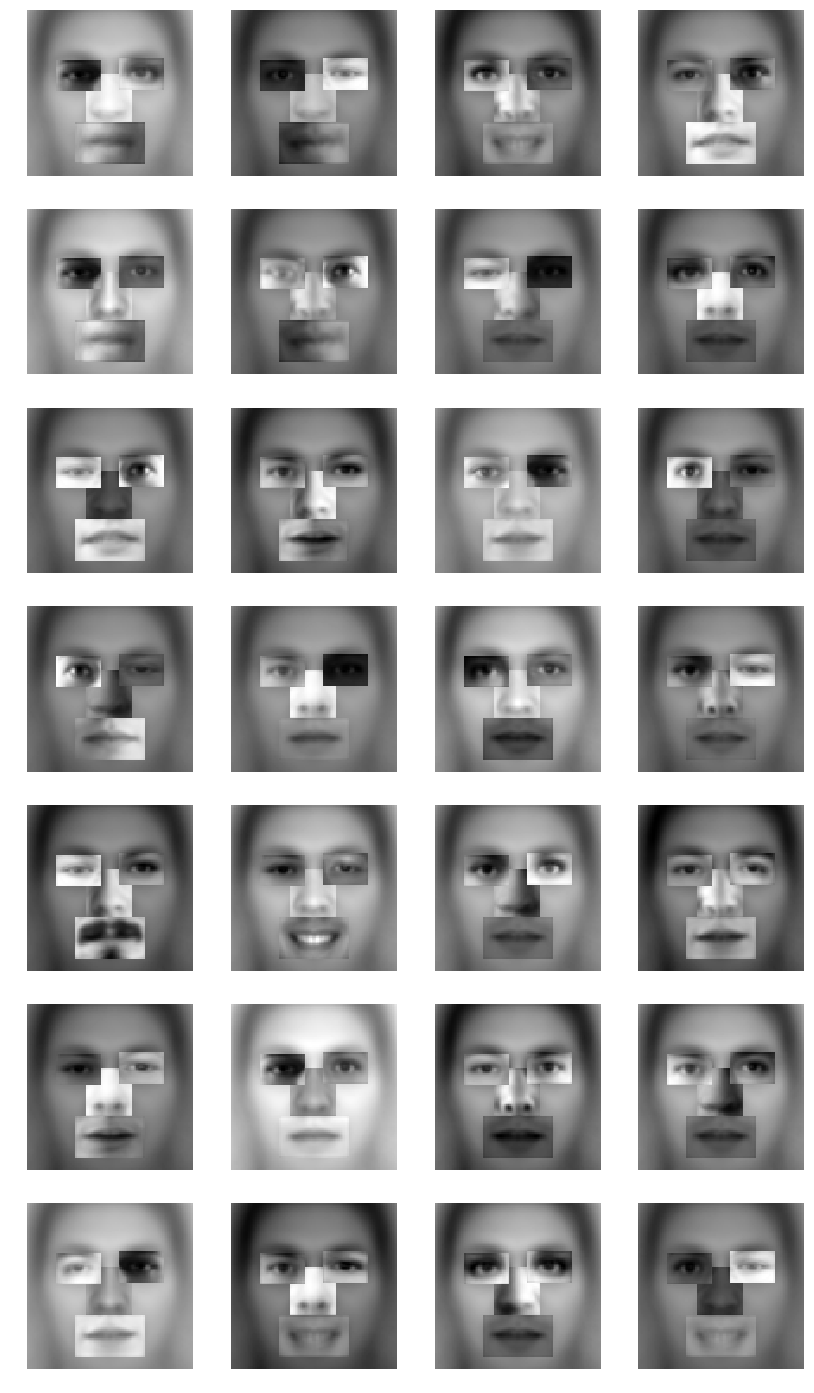

In [23]:
#%% Generate Caricature Faces out of Facial Parts
noseRowCoords     = np.floor(np.array([-0.5,0.5])*targetNoseSize[0] + int(round(facialKeypointsDF.loc[:,'nose_BB_y'].mean()))).astype(int)
noseColCoords     = np.floor(np.array([-0.5,0.5])*targetNoseSize[1] + int(round(facialKeypointsDF.loc[:,'nose_BB_x'].mean()))).astype(int)

mouthRowCoords    = np.floor(np.array([-0.5,0.5])*targetMouthSize[0] + int(round(facialKeypointsDF.loc[:,'mouth_BB_y'].mean()))).astype(int)
mouthColCoords    = np.floor(np.array([-0.5,0.5])*targetMouthSize[1] + int(round(facialKeypointsDF.loc[:,'mouth_BB_x'].mean()))).astype(int)

leftEyeRowCoords  = np.floor(np.array([-0.5,0.5])*targetEyeSize[0] + int(round(facialKeypointsDF.loc[:,'left_eye_BB_y'].mean()))).astype(int)
leftEyeColCoords  = np.floor(np.array([-0.5,0.5])*targetEyeSize[1] + int(round(facialKeypointsDF.loc[:,'left_eye_BB_x'].mean()))).astype(int)

rightEyeRowCoords = np.floor(np.array([-0.5,0.5])*targetEyeSize[0] + int(round(facialKeypointsDF.loc[:,'right_eye_BB_y'].mean()))).astype(int)
rightEyeColCoords = np.floor(np.array([-0.5,0.5])*targetEyeSize[1] + int(round(facialKeypointsDF.loc[:,'right_eye_BB_x'].mean()))).astype(int)

# plot mouths
numFigRows = 7
numFigCols = 4
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,25))
for i in range(numFigRows):
    for j in range(numFigCols):
        #generatedImage = 128.0*np.ones((imHeight,imWidth))
        generatedImage = faceImagesDB.mean(axis=2)
        
        # generate nose
        k = np.random.randint(numClusters_nose)
        noseImage = np.reshape(KmeansModel_nose.cluster_centers_[k,:],targetNoseSize)
        generatedImage[noseRowCoords[0]:noseRowCoords[1],noseColCoords[0]:noseColCoords[1]] = noseImage
        
        # select mouth
        k = np.random.randint(numClusters_mouth)
        mouthImage = np.reshape(KmeansModel_mouth.cluster_centers_[k,:],targetMouthSize)
        generatedImage[mouthRowCoords[0]:mouthRowCoords[1],mouthColCoords[0]:mouthColCoords[1]] = mouthImage
        
        # select left eye
        k = np.random.randint(numClusters_eyes)
        leftEyeImage = np.reshape(KmeansModel_eyes.cluster_centers_[k,:],targetEyeSize)
        generatedImage[leftEyeRowCoords[0]:leftEyeRowCoords[1],leftEyeColCoords[0]:leftEyeColCoords[1]] = leftEyeImage
        
        # select right eye
        k = np.random.randint(numClusters_eyes)
        rightEyeImage = np.reshape(KmeansModel_eyes.cluster_centers_[k,:],targetEyeSize)
        generatedImage[rightEyeRowCoords[0]:rightEyeRowCoords[1],rightEyeColCoords[0]:rightEyeColCoords[1]] = np.fliplr(rightEyeImage)
                
        # show the resulting image
        ax[i][j].imshow(generatedImage, cmap='gray');
        ax[i][j].set_axis_off()


This is definitely amusing! we can see that a lot of times the eyes dont match each other, but overall these still look like faces, and it's still quite fun to look at.

I'll explain what we've done here.
The kmeans model of each part individually, actually models the joint probability density of all the pixels in that part together ("jointly"). This is done seperatley for each part. but, even though there are clear relationships also between parts, we have intentionally decided to disregard them in our "generative model" for the composed faces, and decided to model the relationships between parts as independent random vectors.

There is an important lesson to be learned here, in my opinion (this is also why I've written this kernel).  
It's subtle, but I think it touches on one of the most important parts of statistics and genralization.  

On the one hand, by assuming independence we lose compatibility between parts, but on the other hand we gain in "creativity". i.e. by modeling the parts independent of each other, we are able to "imagine" previously unseen faces.  